#### pre-processing

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [ ]:
# Hyper-parameter and setting
image_size = 28
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_teacher = 10
num_epochs_student = 5
num_classes = 10
#---Regularization term configs---
kd_compress = True  # KD compression in use?
kd_weight = 0.5  # KD weight to control capability of transferring knowledge
kd_temp = 2.0    # KD temperature
#---------------------------------

In [8]:
# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
# Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
# Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/MNIST_M.zip' -d '/content/MNIST_M/'
# Upload directly
# !unzip './MNIST_M.zip

# Ds_target = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
# Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# train_split = 0.8
# train_size = int(train_split * len(Dl_target))
# test_size = len(Dl_target) - train_size
# Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Dl_target, [train_size, test_size])
Ds_target_train = datasets.ImageFolder(root='./MNIST_M//MNIST_M/train', transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root='./MNIST_M//MNIST_M/test', transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=True, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

Streaming output truncated to the last 5000 lines.
 extracting: /content/MNIST_M/MNIST_M/train/9/00008555.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008558.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008563.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008581.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008585.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008586.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008592.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008601.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008608.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008620.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008626.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008630.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008641.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008654.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008669.png  
 extracting: /content/MNIST_M/MNIS

--------------
#### Simple Knowledge Distillation (KD)
Hinton, Geoffrey, Oriol Vinyals, and Jeff Dean. "Distilling the knowledge in a neural network." arXiv preprint arXiv:1503.02531 (2015).\
Referred doc: https://arxiv.org/abs/1503.02531


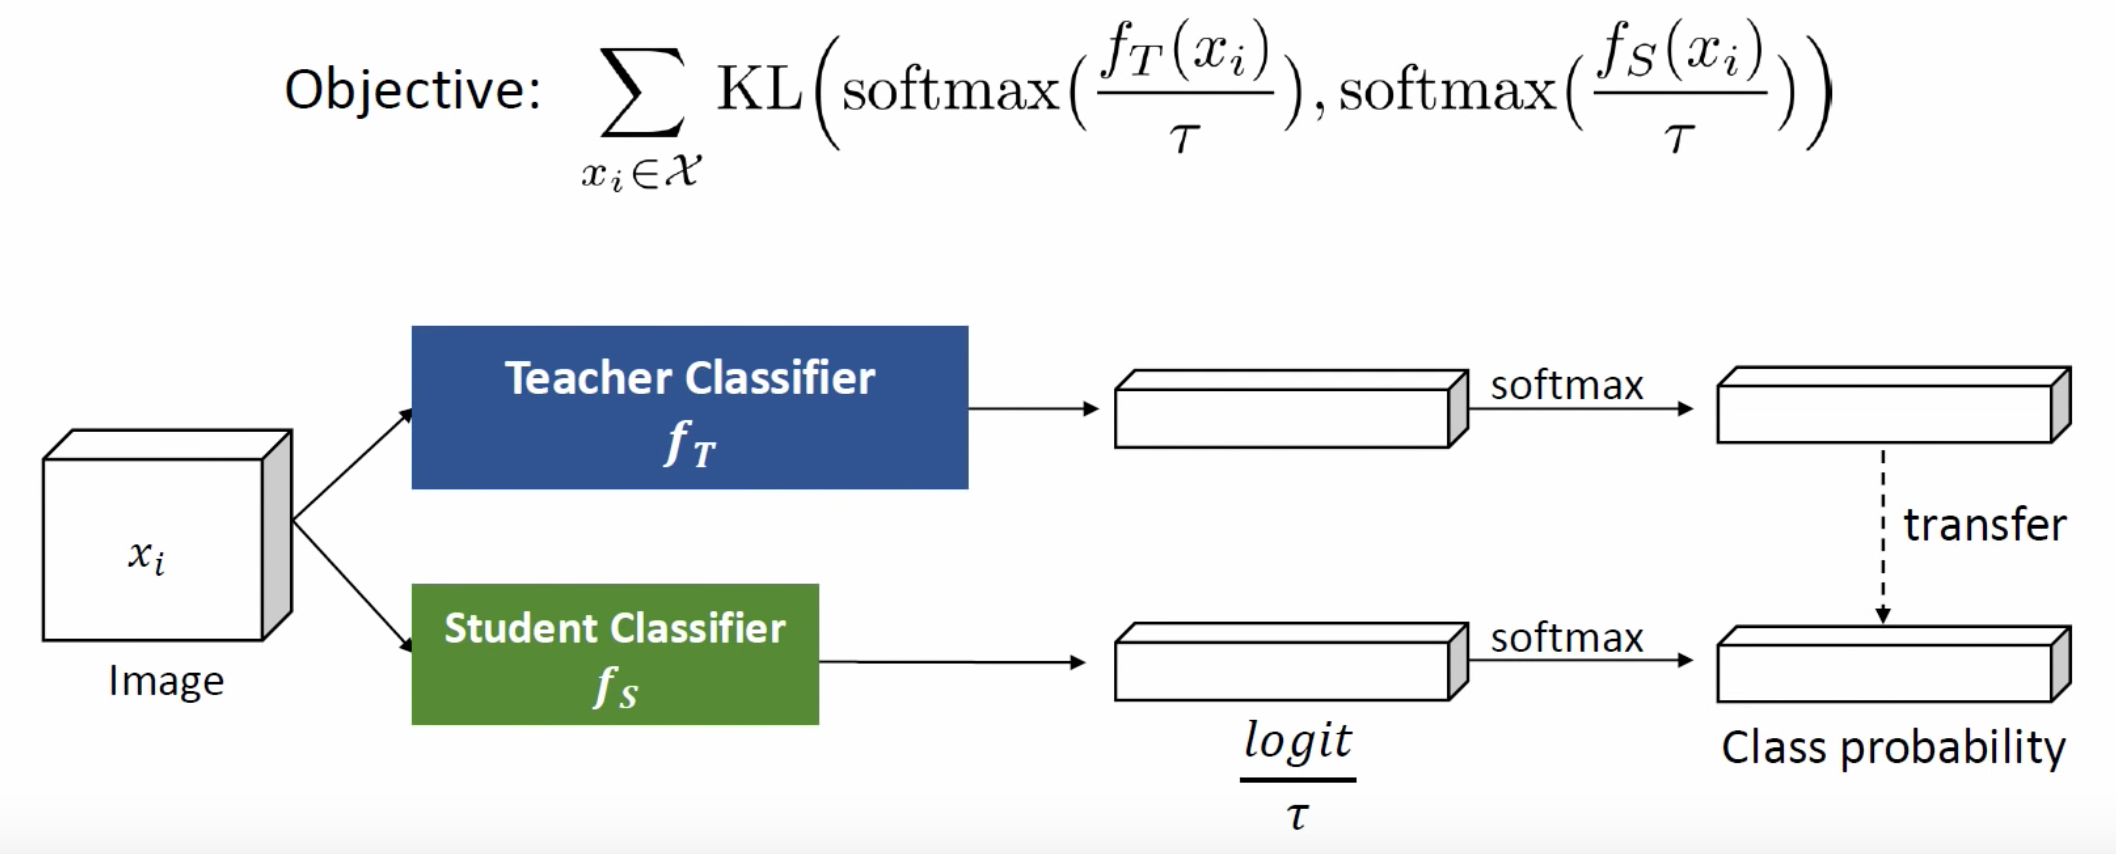

In [ ]:
########################################################################################
class DistillKL(nn.Module):
    """
      Arg:
      Distilling the Knowledge in a Neural Network
    """
    def __init__(self, Temperature):
        super(DistillKL, self).__init__()
        self.Temperature = Temperature

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.Temperature, dim=1)
        #p_s = F.softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.Temperature, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0]
        return loss

class teacher_model(nn.Module):
    def __init__(self, n_C=10):
        super(teacher_model, self).__init__()

        self.feature_extractor = nn.Sequential(
            #  1st block
            nn.Conv2d(3, 64, kernel_size = 3), # 26
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3), # 24
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 12
            # 2nd block
            nn.Conv2d(64, 128, kernel_size=3),  # 10
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),  # 8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 4
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 128 * 4 * 4  # 2048 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(128, n_C),
            nn.LogSoftmax(dim=1),
            # nn.Softmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction

class student_model(nn.Module):
    def __init__(self, n_C=10):
        super(student_model, self).__init__()

        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 5), # 24
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=5),  # 8
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 64 * 4 * 4  # 1024 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(64, n_C),
            nn.LogSoftmax(dim=1),
            # nn.Softmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction


#### Teacher batch running

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           1,792
       BatchNorm2d-2           [-1, 64, 26, 26]             128
              ReLU-3           [-1, 64, 26, 26]               0
            Conv2d-4           [-1, 64, 24, 24]          36,928
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
         MaxPool2d-7           [-1, 64, 12, 12]               0
            Conv2d-8          [-1, 128, 10, 10]          73,856
       BatchNorm2d-9          [-1, 128, 10, 10]             256
             ReLU-10          [-1, 128, 10, 10]               0
           Conv2d-11            [-1, 128, 8, 8]         147,584
      BatchNorm2d-12            [-1, 128, 8, 8]             256
             ReLU-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

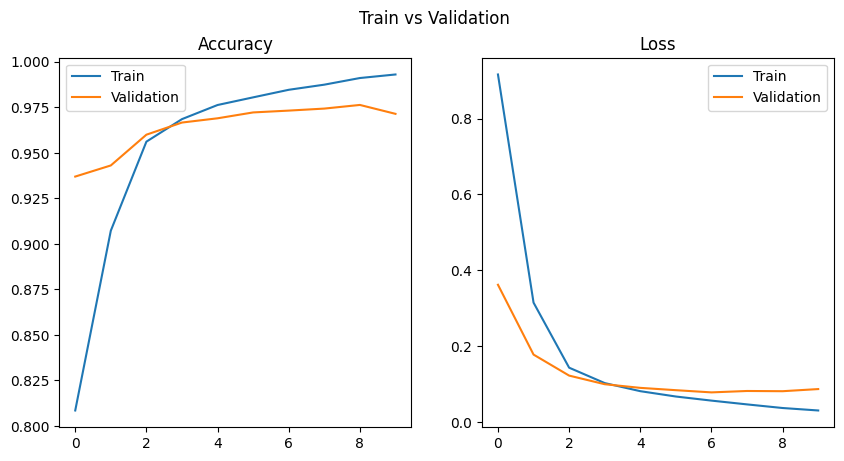

In [ ]:
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()

# network
teacher_fn = teacher_model(n_C=num_classes).to(device)
summary(teacher_fn, input_size=(channel_size, image_size, image_size))

# Optimizer and cost function
optimizer = optim.Adam(teacher_fn.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))

###########################################################################
# 1st step: Training teacher net
t_0 = time.time()
iter_teacher = 0
best_vloss = 1_000_000.
training_logs_teacher = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch_T in range(num_epochs_teacher):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch_T+1:04d} / {num_epochs_teacher:04d}', end='\n============\n')

    for i_T, data_T in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X_T, y_T = data_T[0].to(device), data_T[1].to(device)

        yhat_T = teacher_fn(X_T)
        loss = loss_fn(yhat_T, y_T)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        with torch.no_grad():
          class_prediction_T = teacher_fn(X_T)

        print(f'[{i_T+1}/{len(Dl_tar_training_set)}] '
              f'teacher class loss: {loss.item():.4f} '
              )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction_T.argmax(1) == y_T).float().sum().item()

    training_logs_teacher["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_teacher["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    teacher_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = teacher_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_teacher["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_teacher["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch_T % 1 == 0:
        print(f"Epochs {epoch_T+1}".ljust(10),
            f"train loss {training_logs_teacher['train_loss'][-1]:.5f}",
            f"train acc {training_logs_teacher['train_acc'][-1]:.5f}",

            f"validate loss {training_logs_teacher['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_teacher['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(teacher_fn.state_dict(), path_save_cp+'best_teacher_model.pth')

    iter_teacher += 1

t_end = time.time()-t_0
print(f"Time consumption for teacher net (device:{device}): {t_end} sec")

plot_graph(training_logs_teacher)

#### Teacher to student distillation

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           2,432
       BatchNorm2d-2           [-1, 32, 24, 24]              64
         MaxPool2d-3           [-1, 32, 12, 12]               0
              ReLU-4           [-1, 32, 12, 12]               0
            Conv2d-5             [-1, 64, 8, 8]          51,264
       BatchNorm2d-6             [-1, 64, 8, 8]             128
         MaxPool2d-7             [-1, 64, 4, 4]               0
              ReLU-8             [-1, 64, 4, 4]               0
         Dropout2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 64]          65,600
      BatchNorm1d-11                   [-1, 64]             128
          Dropout-12                   [-1, 64]               0
             ReLU-13                   [-1, 64]               0
           Linear-14                   

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>    
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    AssertionError: can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[9/29] student class loss: 2.7619 Knowledge distillation loss: 1.8619 
[10/29] student class loss: 2.7052 Knowledge distillation loss: 1.8422 
[11/29] student class loss: 2.6530 Knowledge distillation loss: 1.7959 
[12/29] student class loss: 2.5868 Knowledge distillation loss: 1.7584 
[13/29] student class loss: 2.5089 Knowledge distillation loss: 1.6831 
[14/29] student class loss: 2.4820 Knowledge distillation loss: 1.6811 
[15/29] student class loss: 2.4543 Knowledge distillation loss: 1.6840 
[16/29] student class loss: 2.3887 Knowledge distillation loss: 1.5834 
[17/29] student class loss: 2.3466 Knowledge distillation loss: 1.5854 
[18/29] student class loss: 2.2844 Knowledge distillation loss: 1.5255 
[19/29] student class loss: 2.2490 Knowledge distillation loss: 1.4982 
[20/29] student class loss: 2.2354 Knowledge distillation loss: 1.4796 
[21/29] student class loss: 2.1684 Knowledge distillation loss: 1.4350 
[22/29] student class loss: 2.1002 Knowledge distillation loss: 1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
if w.is_alive():
  File "/usr/lib/

[9/29] student class loss: 0.9435 Knowledge distillation loss: 0.6658 
[10/29] student class loss: 0.9373 Knowledge distillation loss: 0.6012 
[11/29] student class loss: 0.9556 Knowledge distillation loss: 0.5718 
[12/29] student class loss: 0.9088 Knowledge distillation loss: 0.5792 
[13/29] student class loss: 0.8655 Knowledge distillation loss: 0.5620 
[14/29] student class loss: 0.8301 Knowledge distillation loss: 0.5948 
[15/29] student class loss: 0.7897 Knowledge distillation loss: 0.5654 
[16/29] student class loss: 0.7852 Knowledge distillation loss: 0.5704 
[17/29] student class loss: 0.7780 Knowledge distillation loss: 0.5616 
[18/29] student class loss: 0.7446 Knowledge distillation loss: 0.5191 
[19/29] student class loss: 0.7500 Knowledge distillation loss: 0.5068 
[20/29] student class loss: 0.7359 Knowledge distillation loss: 0.4895 
[21/29] student class loss: 0.7055 Knowledge distillation loss: 0.4559 
[22/29] student class loss: 0.7138 Knowledge distillation loss: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

[5/29] student class loss: 0.5917 Knowledge distillation loss: 0.4145 
[6/29] student class loss: 0.5993 Knowledge distillation loss: 0.4088 
[7/29] student class loss: 0.5664 Knowledge distillation loss: 0.4217 
[8/29] student class loss: 0.5689 Knowledge distillation loss: 0.3903 
[9/29] student class loss: 0.5693 Knowledge distillation loss: 0.3745 
[10/29] student class loss: 0.5920 Knowledge distillation loss: 0.3897 
[11/29] student class loss: 0.5681 Knowledge distillation loss: 0.3906 
[12/29] student class loss: 0.5688 Knowledge distillation loss: 0.4087 
[13/29] student class loss: 0.5479 Knowledge distillation loss: 0.3789 
[14/29] student class loss: 0.5487 Knowledge distillation loss: 0.3758 
[15/29] student class loss: 0.5406 Knowledge distillation loss: 0.3764 
[16/29] student class loss: 0.5560 Knowledge distillation loss: 0.3673 
[17/29] student class loss: 0.5609 Knowledge distillation loss: 0.3853 
[18/29] student class loss: 0.5140 Knowledge distillation loss: 0.345

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[5/29] student class loss: 0.4843 Knowledge distillation loss: 0.3304 
[6/29] student class loss: 0.4819 Knowledge distillation loss: 0.3198 
[7/29] student class loss: 0.4810 Knowledge distillation loss: 0.3202 
[8/29] student class loss: 0.4814 Knowledge distillation loss: 0.3256 
[9/29] student class loss: 0.4933 Knowledge distillation loss: 0.3427 
[10/29] student class loss: 0.4695 Knowledge distillation loss: 0.3281 
[11/29] student class loss: 0.4731 Knowledge distillation loss: 0.3186 
[12/29] student class loss: 0.4781 Knowledge distillation loss: 0.3192 
[13/29] student class loss: 0.4925 Knowledge distillation loss: 0.3161 
[14/29] student class loss: 0.4648 Knowledge distillation loss: 0.3190 
[15/29] student class loss: 0.4723 Knowledge distillation loss: 0.3245 
[16/29] student class loss: 0.4667 Knowledge distillation loss: 0.2930 
[17/29] student class loss: 0.4534 Knowledge distillation loss: 0.3022 
[18/29] student class loss: 0.4733 Knowledge distillation loss: 0.341

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c77f05a5990>self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorself._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
:     can only test a child processif w.is_alive():

  File "/usr/lib/

[5/29] student class loss: 0.4408 Knowledge distillation loss: 0.3263 
[6/29] student class loss: 0.4384 Knowledge distillation loss: 0.3163 
[7/29] student class loss: 0.4424 Knowledge distillation loss: 0.2996 
[8/29] student class loss: 0.4379 Knowledge distillation loss: 0.2833 
[9/29] student class loss: 0.4008 Knowledge distillation loss: 0.2896 
[10/29] student class loss: 0.4351 Knowledge distillation loss: 0.3353 
[11/29] student class loss: 0.4258 Knowledge distillation loss: 0.3177 
[12/29] student class loss: 0.4151 Knowledge distillation loss: 0.2971 
[13/29] student class loss: 0.4084 Knowledge distillation loss: 0.2821 
[14/29] student class loss: 0.4154 Knowledge distillation loss: 0.3058 
[15/29] student class loss: 0.4230 Knowledge distillation loss: 0.3056 
[16/29] student class loss: 0.4288 Knowledge distillation loss: 0.3018 
[17/29] student class loss: 0.4482 Knowledge distillation loss: 0.2964 
[18/29] student class loss: 0.4266 Knowledge distillation loss: 0.277

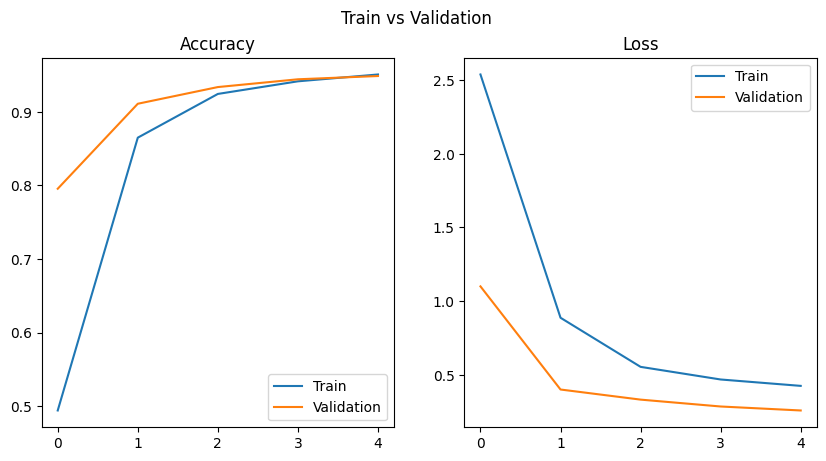

In [ ]:
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()

# network
teacher_fn = teacher_model(n_C=num_classes).to(device)
teacher_model_dict=teacher_fn.state_dict()
path = path_save_cp+'/best_teacher_model.pth'
pretrained_dict = torch.load(path)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in teacher_model_dict) and (teacher_model_dict[k].shape == pretrained_dict[k].shape)}
teacher_model_dict.update(pretrained_dict)
teacher_fn.load_state_dict(teacher_model_dict)

student_fn = student_model(n_C=num_classes).to(device)
summary(student_fn, input_size=(channel_size, image_size, image_size))

# Optimizer and cost function
optimizer = optim.Adam(student_fn.parameters(), lr)
# optimizer = optim.SGD(student_fn.parameters(), lr, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))

###########################################################################
# 2nd step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch_S in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch_S+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i_S, data_S in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X_S, y_S = data_S[0].to(device), data_S[1].to(device)

        yhat_S = student_fn(X_S)
        loss = loss_fn(yhat_S, y_S)                 # source classification loss

        #Distilling
        if kd_compress:
          # No need to update teacher net (freeze teacher weights)
          with torch.no_grad():
              yhat_T = teacher_fn(X_S)
          loss_kd = DistillKL(Temperature=kd_temp)(yhat_S, yhat_T)
          loss += kd_weight * loss_kd

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        with torch.no_grad():
          class_prediction_S = student_fn(X_S)

        base_message = (f'[{i_S+1}/{len(Dl_tar_training_set)}] '
                        f'student class loss: {loss.item():.4f} ')
        if kd_compress:
          base_message += f'Knowledge distillation loss: {loss_kd.item():.4f} '
        print(base_message)

        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction_S.argmax(1) == y_S).float().sum().item()

    training_logs_student["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch_S % 1 == 0:
        print(f"Epochs {epoch_S+1}".ljust(10),
            f"train loss {training_logs_student['train_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn.state_dict(), path_save_cp+'best_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

# Summarize
Knowledge distillation is a machine learning technique where a smaller, simpler model (the "student") is trained to replicate the behavior of a larger, more complex model (the "teacher"). The process involves using the teacher model to generate soft predictions or probability distributions for a dataset, which are then used to train the student model. This approach leverages the teacher's more nuanced understanding of the data to guide the student, enabling the smaller model to achieve comparable performance while being more efficient in terms of computation and memory. Knowledge distillation is particularly useful for deploying models in resource-constrained environments.

# In-class exercises

จงกลั่นความรู้จากตัวอย่างโมเดลครูและโมเดลนักเรียนในตัวอย่าง โดยการปรับน้ำหนักควบคุมและอุณหภูมิ

```
kd_weight = [0.2, 0.4, 0.6, 0.8, 1.0]
kd_temp = [0.25, 0.5, 1.25, 1.5, 1.75, 2.0]
```

จงเลือกค่าจากคู่ [kd_weight, kd_temp] ที่ดีที่สุดสำหรับการกลั่นความรู้ เปรียบเทียบและอธิบายผลที่จำนวนรอบการเรียนรู้วนซ้ำที่ 5 รอบเท่ากัน เมื่อเทียบกับกรณีไม่มีกลั่นความรู้

```
kd_weight, kd_temp = 0.0, 1.0
```

จัดทำเป็น PDF ส่ง

# Homework
จงบีบอัดและกลั่นความรู้จาก Pretrained ResNet-50 ไปยัง ResNet-18 (Referred model in W4-2) โดยให้ตั้งค่า hyper-parameter ทั้งแบบไม่กลั่นความรู้และบีบอัดกลั่นความรู้ ที่ setting เดียวกันและ 10 รอบการวนซ้ำเท่ากัน โดยปรับในส่วนของ

กรณีไม่กลั่นความรู้
*   Train ResNet18 only

กรณีกลั่นความรู้
*   Pretrained ResNet50 (freezed weight: ImageNet-1K) --> ResNet18
*   น้ำหนักอุณหภูมิ (Temperature) ในการ softening outputs
```
kd_temp = [1.0, 1.5, 2.0]
```
*   น้ำหนักควบคุม (kd_weight) ความสามารถส่งผ่านของ knowledge distillation
```
kd_weight = [0.0, 0.3, 0.5, 0.8, 1.0]
```




\
>เปรียบเทียบและอภิปรายผล Quantitative and visualization results (acc., loss, precision, recall, F1, confusion matrix, etc.) จัดส่งเป็น PDF ระหว่าง non-distilled student
```
kd_weight, kd_temp = 0.0, 1.0
```
กับ distilled student (จากการปรับ temp และ kd_weight ในหลาย ๆ ค่าและเลือกค่าจากคู่ที่ดีที่สุดจากการฝึกฝนการกลั่นความรู้)
```
kd_weight, kd_temp = best, best
```





In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os

In [1]:
# Hyper-parameter and setting
image_size = 28
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_teacher = 10
num_epochs_student = 10
num_classes = 10
#---Regularization term configs---
kd_compress = True  # KD compression in use?
kd_weight = 0.3  # KD weight to control capability of transferring knowledge
kd_temp = 1.0    # KD temperature
#---------------------------------

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Model Selection
def ResNet18(n_C=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=n_C)

def ResNet34(n_C=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=n_C)

def ResNet50(n_C=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=n_C)

def ResNet101(n_C=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=n_C)

def ResNet152(n_C=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=n_C)

!pip install wget
import wget
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d90a986f74e05401939187aecd2c514a24879ea7978b49255dc8ffdf15a08b67
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
model_urls = {
     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
 }

In [11]:
########################################################################################
class DistillKL(nn.Module):
    """
      Arg:
      Distilling the Knowledge in a Neural Network
    """
    def __init__(self, Temperature):
        super(DistillKL, self).__init__()
        self.Temperature = Temperature

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.Temperature, dim=1)
        #p_s = F.softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.Temperature, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0]
        return loss

class teacher_model(nn.Module):
    def __init__(self, n_C=10):
        super(teacher_model, self).__init__()

        self.feature_extractor = nn.Sequential(
            #  1st block
            nn.Conv2d(3, 64, kernel_size = 3), # 26
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3), # 24
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 12
            # 2nd block
            nn.Conv2d(64, 128, kernel_size=3),  # 10
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),  # 8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 4
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 128 * 4 * 4  # 2048 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(128, n_C),
            nn.LogSoftmax(dim=1),
            # nn.Softmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction

class student_model(nn.Module):
    def __init__(self, n_C=10):
        super(student_model, self).__init__()

        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 5), # 24
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=5),  # 8
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 64 * 4 * 4  # 1024 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(64, n_C),
            nn.LogSoftmax(dim=1),
            # nn.Softmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction


In [5]:
# @title Function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional, List
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp
import matplotlib
matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""

def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7

def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)


"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor,
                             target_feature: torch.Tensor,
                             source_labels: torch.Tensor,
                             target_labels: torch.Tensor,
                             filename: str,
                             source_color='r',
                             target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage
# visualize(source_feature, target_feature, source_labels, target_labels, 'tsne_plot.png')





from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


def Adist_calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1))
    target_label = torch.zeros((target_feature.shape[0], 1))
    feature = torch.cat([source_feature, target_feature], dim=0)
    label = torch.cat([source_label, target_label], dim=0)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    generator = torch.Generator(device=device)

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, generator=generator)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, generator=generator)

    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0
    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance




class AverageMeter(object):
    r"""Computes and stores the average and current value.
    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        if self.count > 0:
            self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class AverageMeterDict(object):
    def __init__(self, names: List, fmt: Optional[str] = ':f'):
        self.dict = {
            name: AverageMeter(name, fmt) for name in names
        }

    def reset(self):
        for meter in self.dict.values():
            meter.reset()

    def update(self, accuracies, n=1):
        for name, acc in accuracies.items():
            self.dict[name].update(acc, n)

    def average(self):
        return {
            name: meter.avg for name, meter in self.dict.items()
        }

    def __getitem__(self, item):
        return self.dict[item]


class Meter(object):
    """Computes and stores the current value."""
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0

    def update(self, val):
        self.val = val

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [9]:
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()

# network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_fn = ResNet50(n_C=num_classes).to(device)
summary(teacher_fn, input_size=(channel_size, image_size, image_size))

download_n_load_model(teacher_fn, 'resnet50')

# Optimizer and cost function
optimizer = optim.Adam(teacher_fn.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))

###########################################################################
# 1st step: Training teacher net
t_0 = time.time()
iter_teacher = 0
best_vloss = 1_000_000.
training_logs_teacher = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
stored_lbs_tar = torch.empty(0, dtype=torch.float32)
stored_preds_tar = torch.empty(0, dtype=torch.float32)
for epoch_T in range(num_epochs_teacher):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch_T+1:04d} / {num_epochs_teacher:04d}', end='\n============\n')

    for i_T, data_T in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X_T, y_T = data_T[0].to(device), data_T[1].to(device)

        yhat_T = teacher_fn(X_T)
        loss = loss_fn(yhat_T, y_T)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        with torch.no_grad():
          class_prediction_T = teacher_fn(X_T)

        # print(f'[{i_T+1}/{len(Dl_tar_training_set)}] '
        #       f'teacher class loss: {loss.item():.4f} '
        #       )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        stored_lbs_tar = torch.cat((stored_lbs_tar, y_T.to("cpu")), 0) # Send y_t to cpu to match stored_lbs_tar
        _, prediction_t = torch.max(class_prediction_T, 1)
        stored_preds_tar = torch.cat((stored_preds_tar.to(device), prediction_t), 0)

        train_loss += loss.item()
        train_correct += (class_prediction_T.argmax(1) == y_T).float().sum().item()

    training_logs_teacher["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_teacher["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    teacher_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = teacher_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_teacher["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_teacher["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch_T % 1 == 0:
        print(f"Epochs {epoch_T+1}".ljust(10),
            f"train loss {training_logs_teacher['train_loss'][-1]:.5f}",
            f"train acc {training_logs_teacher['train_acc'][-1]:.5f}",

            f"validate loss {training_logs_teacher['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_teacher['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(teacher_fn.state_dict(), path_save_cp+'best_teacher_model.pth')

    iter_teacher += 1

t_end = time.time()-t_0
print(f"Time consumption for teacher net (device:{device}): {t_end} sec")

plot_graph(training_logs_teacher)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]           4,096
       BatchNorm2d-5             [-1, 64, 7, 7]             128
            Conv2d-6             [-1, 64, 7, 7]          36,864
       BatchNorm2d-7             [-1, 64, 7, 7]             128
            Conv2d-8            [-1, 256, 7, 7]          16,384
       BatchNorm2d-9            [-1, 256, 7, 7]             512
           Conv2d-10            [-1, 256, 7, 7]          16,384
      BatchNorm2d-11            [-1, 256, 7, 7]             512
       Bottleneck-12            [-1, 256, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]          16,384
      BatchNorm2d-14             [-1, 6

<ipython-input-3-5a5bae66c2a8>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'./{model_name}.pth')


load checkpoint...resnet50
epochs 0001 / 0010
Epochs 1   train loss 1.27772 train acc 0.64379 validate loss 0.39388 validate acc 0.88035
--------------------------------------------------------------------------------
epochs 0002 / 0010
Epochs 2   train loss 1.59481 train acc 0.53825 validate loss 0.51896 validate acc 0.83091
--------------------------------------------------------------------------------
epochs 0003 / 0010
Epochs 3   train loss 0.36781 train acc 0.88665 validate loss 0.25256 validate acc 0.91601
--------------------------------------------------------------------------------
epochs 0004 / 0010
Epochs 4   train loss 0.22074 train acc 0.93075 validate loss 0.19131 validate acc 0.93479
--------------------------------------------------------------------------------
epochs 0005 / 0010
Epochs 5   train loss 0.15951 train acc 0.95126 validate loss 0.17030 validate acc 0.94201
--------------------------------------------------------------------------------
epochs 0006 / 0010

In [24]:
# Hyper-parameter and setting
image_size = 28
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_teacher = 10
num_epochs_student = 10
num_classes = 10
#---Regularization term configs---
kd_compress = True  # KD compression in use?
kd_weight,kd_temp = 0.0,2.0   # KD weight to control capability of transferring knowledge
#---------------------------------

In [25]:
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()

# network
teacher_fn = ResNet50(n_C=num_classes).to(device)
teacher_model_dict=teacher_fn.state_dict()
path = path_save_cp+'/best_teacher_model.pth'
pretrained_dict = torch.load(path)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in teacher_model_dict) and (teacher_model_dict[k].shape == pretrained_dict[k].shape)}
teacher_model_dict.update(pretrained_dict)
teacher_fn.load_state_dict(teacher_model_dict)

student_fn = ResNet18(n_C=num_classes).to(device)
summary(student_fn, input_size=(channel_size, image_size, image_size))

# Optimizer and cost function
optimizer = torch.optim.SGD(student_fn.parameters(), lr=lr, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))

###########################################################################
# 2nd step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
stored_lbs_tar = torch.empty(0, dtype=torch.float32)
stored_preds_tar = torch.empty(0, dtype=torch.float32)
for epoch_S in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch_S+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i_S, data_S in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X_S, y_S = data_S[0].to(device), data_S[1].to(device)

        yhat_S = student_fn(X_S)
        loss = loss_fn(yhat_S, y_S)                 # source classification loss

        #Distilling
        if kd_compress:
          # No need to update teacher net (freeze teacher weights)
          with torch.no_grad():
              yhat_T = teacher_fn(X_S)
          loss_kd = DistillKL(Temperature=kd_temp)(yhat_S, yhat_T)
          loss += kd_weight * loss_kd

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        with torch.no_grad():
          class_prediction_S = student_fn(X_S)

        base_message = (f'[{i_S+1}/{len(Dl_tar_training_set)}] '
                        f'student class loss: {loss.item():.4f} ')
        if kd_compress:
          base_message += f'Knowledge distillation loss: {loss_kd.item():.4f} '
        #print(base_message)

        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        stored_lbs_tar = torch.cat((stored_lbs_tar, y_T.to("cpu")), 0) # Send y_t to cpu to match stored_lbs_tar
        _, prediction_t = torch.max(class_prediction_T, 1)
        stored_preds_tar = torch.cat((stored_preds_tar.to(device), prediction_t), 0)

        train_loss += loss.item()
        train_correct += (class_prediction_S.argmax(1) == y_S).float().sum().item()

    training_logs_student["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch_S % 1 == 0:
        print(f"Epochs {epoch_S+1}".ljust(10),
            f"train loss {training_logs_student['train_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn.state_dict(), path_save_cp+'best_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

<ipython-input-25-4a37cde6f361>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]          36,864
       BatchNorm2d-5             [-1, 64, 7, 7]             128
            Conv2d-6             [-1, 64, 7, 7]          36,864
       BatchNorm2d-7             [-1, 64, 7, 7]             128
        BasicBlock-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,864
      BatchNorm2d-10             [-1, 64, 7, 7]             128
           Conv2d-11             [-1, 64, 7, 7]          36,864
      BatchNorm2d-12             [-1, 64, 7, 7]             128
       BasicBlock-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 12

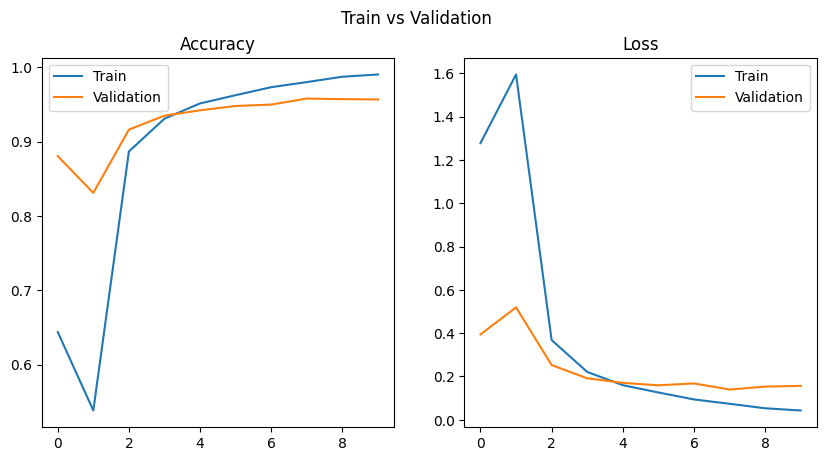

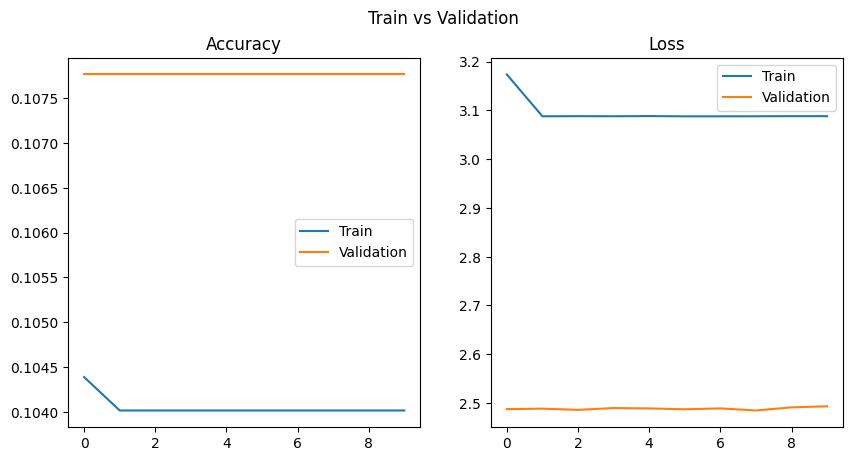

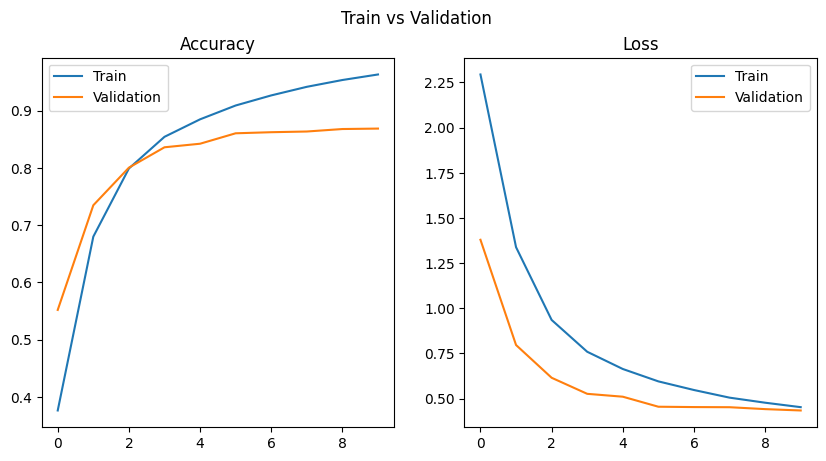

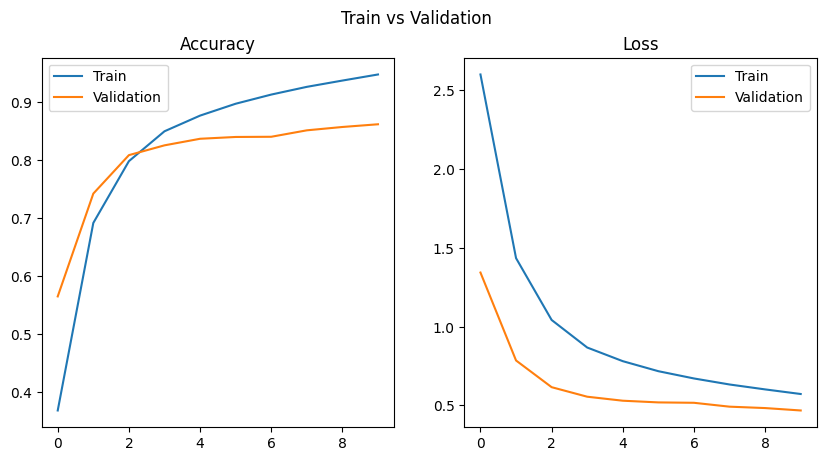

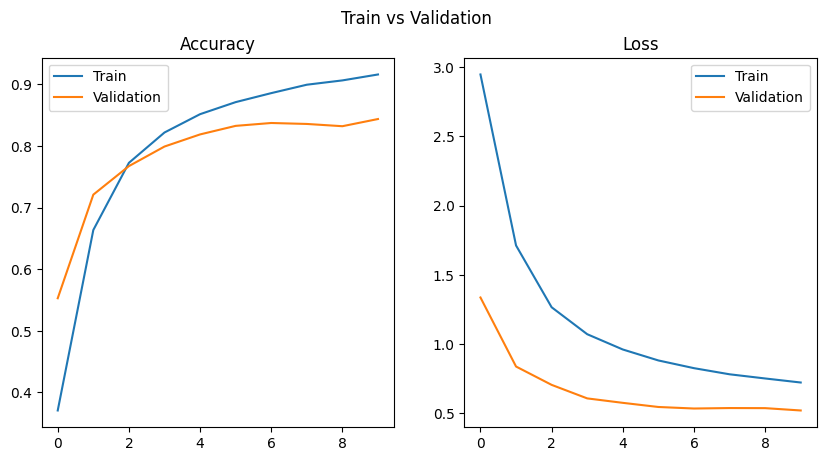

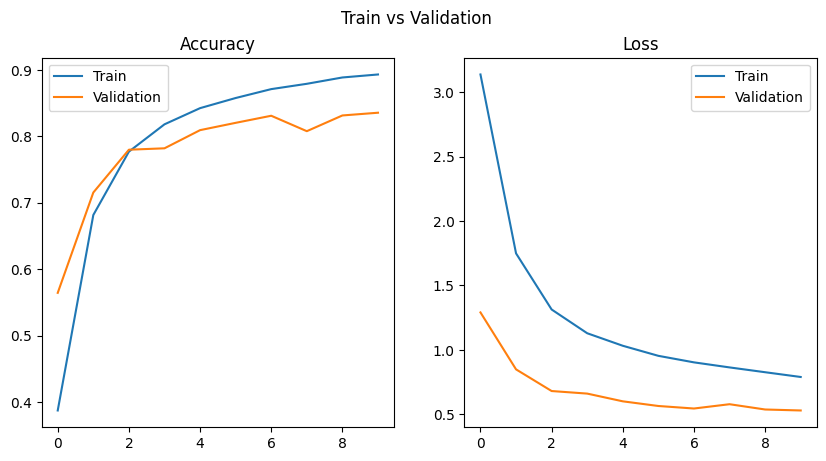

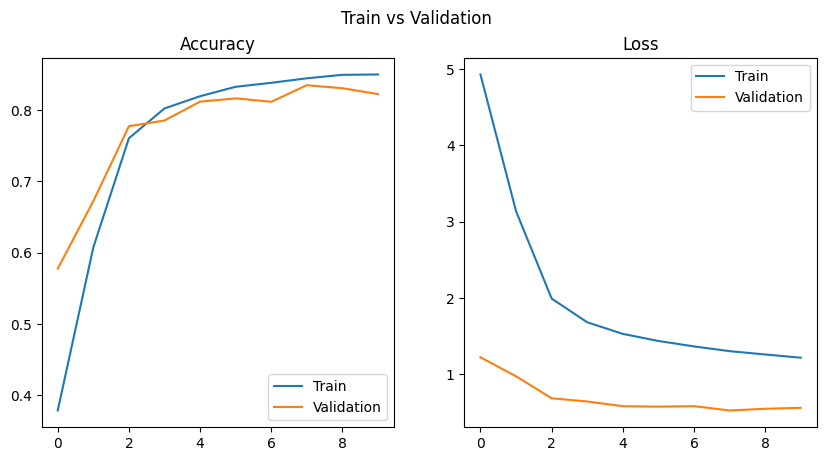

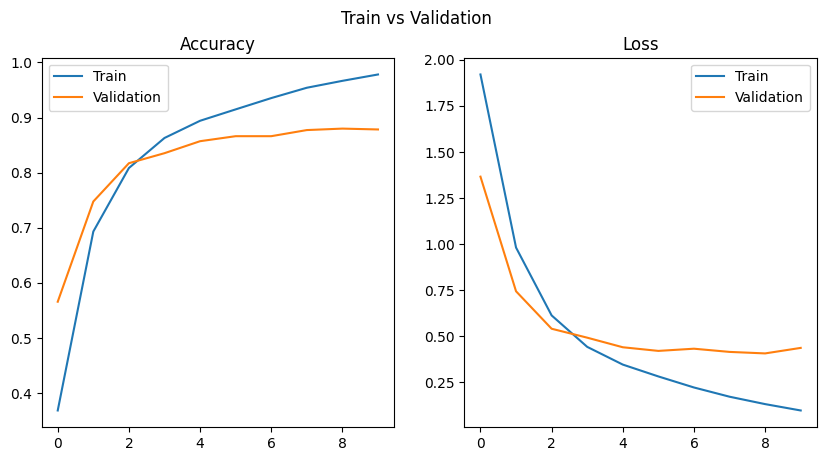

<Figure size 640x480 with 0 Axes>

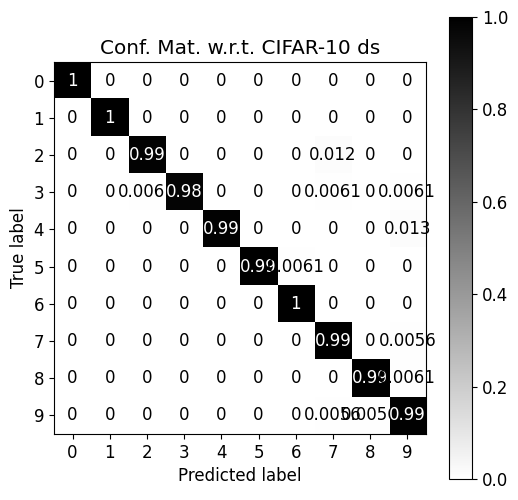

Precision/Recall/F-beta score: (0.9928481750004194, 0.9927579963789982, 0.9927733930959637, None)
NMI score: 0.9814272602850964, RI score: 0.9835926466506784


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score
import numpy as np

%matplotlib inline
# Assuming stored_lbs_tar and stored_preds_tar are defined and available
lb = stored_lbs_tar.cpu()
prd = stored_preds_tar.cpu()

# Define class labels
pos_labels = np.arange(10)
lb_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Confusion matrix
cm_target = confusion_matrix(y_true=lb, y_pred=prd, labels=pos_labels, normalize='true')

# Plot confusion matrix
plt.figure()
plt.rcParams.update({'font.size': 12, 'figure.figsize': (6, 6)})
ConfusionMatrixDisplay(confusion_matrix=cm_target, display_labels=lb_classes).plot(cmap=plt.cm.binary)
plt.title('Conf. Mat. w.r.t. CIFAR-10 ds')
plt.show()

# Precision/Recall/F-beta score
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0, beta=1.0))

# NMI score
nmi_score = normalized_mutual_info_score(labels_true=lb, labels_pred=prd, average_method='arithmetic')

# RI score
ri_score = adjusted_rand_score(labels_true=lb, labels_pred=prd)
print(f"NMI score: {nmi_score}, RI score: {ri_score}")
